# Análisis Exploratorio de Datos (EDA)

Este notebook realiza un análisis exploratorio de los datos de inspecciones de establecimientos de comida en Chicago.

In [5]:
import pandas as pd
import boto3
import pickle
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from matplotlib.ticker import FuncFormatter
from datetime import date
from IPython.display import display, HTML
import base64
from io import BytesIO

In [6]:
# Cargar configuración
with open('credentials.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Configurar el cliente de boto3
boto3.setup_default_session(
    aws_access_key_id=config['s3']['aws_access_key_id'],
    aws_secret_access_key=config['s3']['aws_secret_access_key'],
    aws_session_token=config['s3']['aws_session_token']
)

# Definir la región
AWS_REGION = "us-east-1"

## 1. Cargar datos de S3

In [7]:
def carga_datos_s3(bucket, bucket_path):
    s3 = boto3.client('s3', region_name=AWS_REGION)
    response = s3.list_objects_v2(Bucket=bucket, Prefix=bucket_path)
    latest_file = max(response['Contents'], key=lambda x: x['LastModified'])['Key']
    
    obj = s3.get_object(Bucket=bucket, Key=latest_file)
    return pickle.loads(obj['Body'].read())

bucket = f"aplicaciones-cd-1-{config['iexe']['matricula']}"
bucket_path = "limpieza/"
df = carga_datos_s3(bucket, bucket_path)
print(f"Se cargaron {len(df)} registros de S3.")
df.head()

Se cargaron 279463 registros de S3.


,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
2,67733,WOLCOTT'S,TROQUET,1992040,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
3,104236,TEMPO CAFE,TEMPO CAFE,80916,Restaurant,Risk 1 (High),6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
4,70269,mr.daniel's,mr.daniel's,1899292,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04,License Re-Inspection,Pass,41.938443,-87.768318,"{'latitude': '41.93844282365204', 'longitude':...",NaN
5,52234,Cafe 608,Cafe 608,2013328,Restaurant,Risk 1 (High),608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN


## 2. Top 5 tipos de establecimientos con más inspecciones

In [8]:
# Función para formatear los números con comas
def format_with_commas(x, p):
    return f"{x:,.0f}"

# Configuración general de las gráficas
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

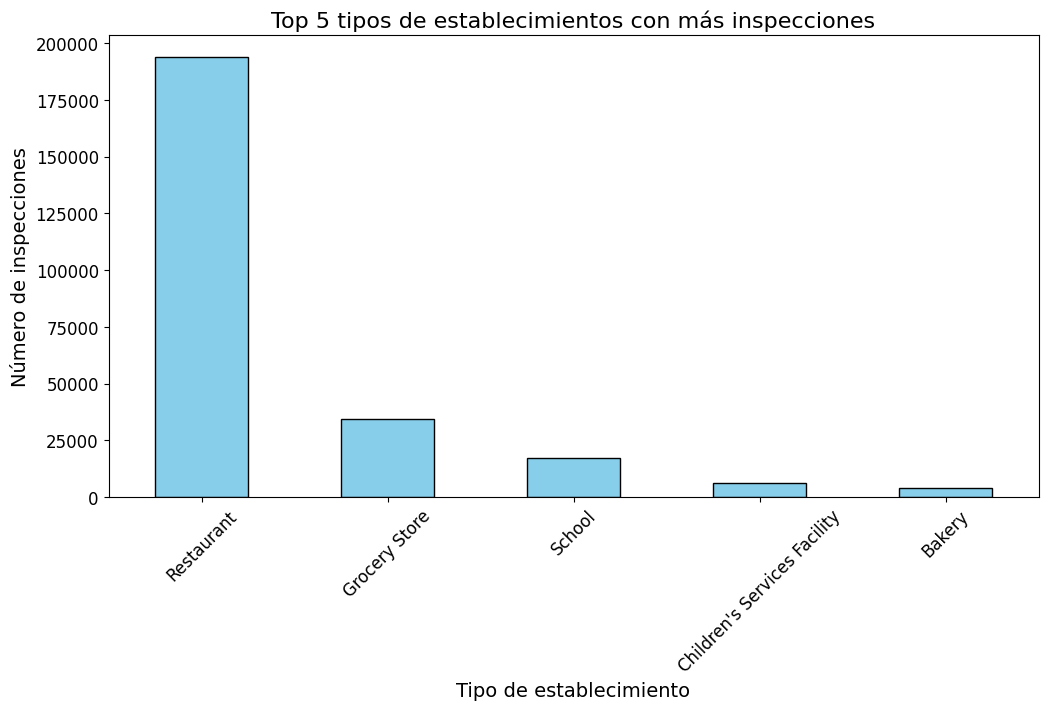

In [24]:
top_5_establecimientos = df['facility_type'].value_counts().head()
plt.figure(figsize=(12, 6))
ax = top_5_establecimientos.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 5 tipos de establecimientos con más inspecciones')
plt.ylabel('Número de inspecciones')
plt.xlabel('Tipo de establecimiento')
plt.xticks(rotation=45)
plt.show()


## 3. Inspecciones por año

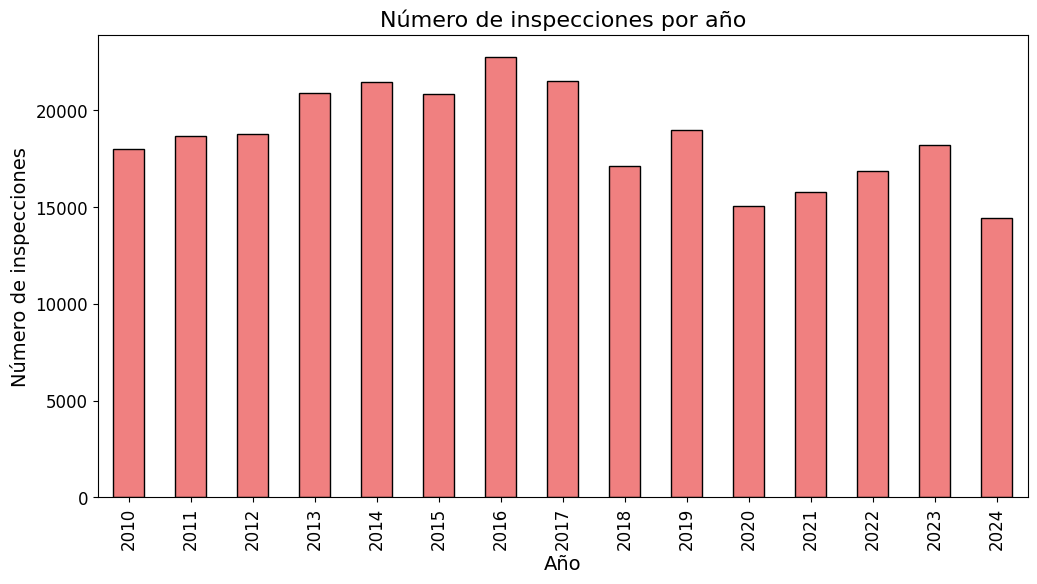

In [25]:
df['year'] = pd.to_datetime(df['inspection_date']).dt.year
inspecciones_por_anio = df['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
ax = inspecciones_por_anio.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Número de inspecciones por año')
plt.ylabel('Número de inspecciones')
plt.xlabel('Año')
plt.show()


## 4. Top 5 tipos de inspecciones

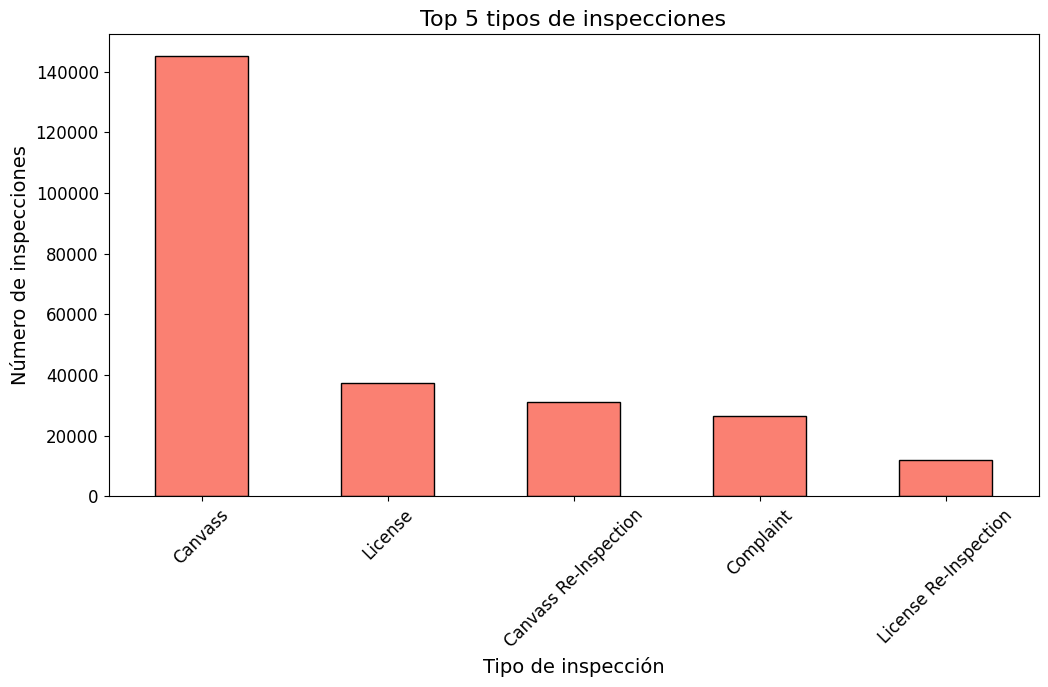

In [26]:
top_5_inspecciones = df['inspection_type'].value_counts().head()
plt.figure(figsize=(12, 6))
ax = top_5_inspecciones.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 5 tipos de inspecciones')
plt.ylabel('Número de inspecciones')
plt.xlabel('Tipo de inspección')
plt.xticks(rotation=45)
plt.show()


## 5. Porcentaje de los top 5 tipos de inspecciones

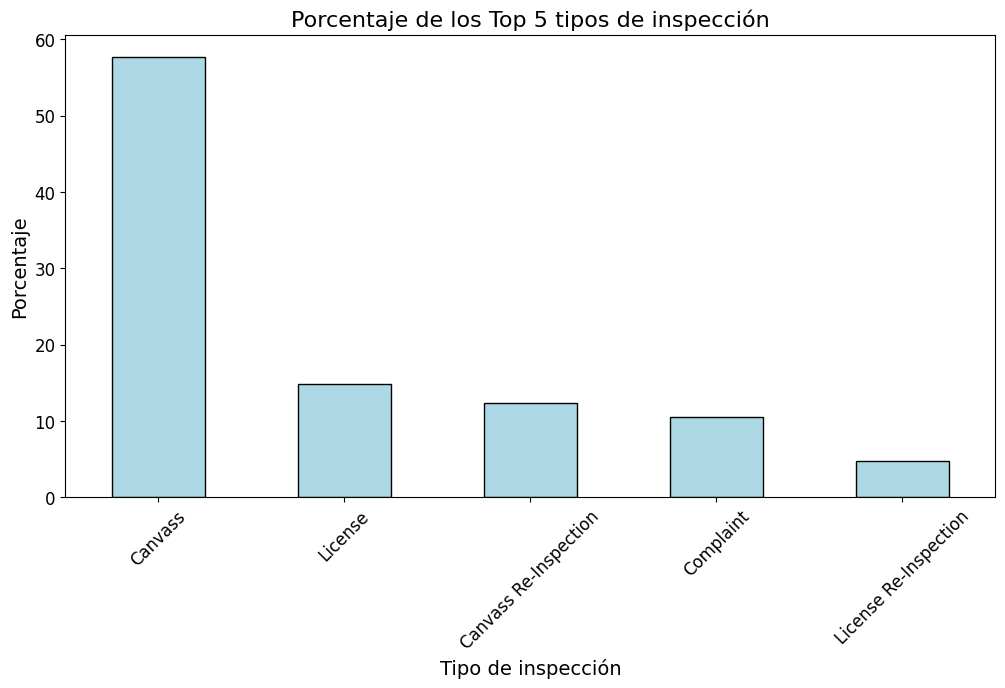

In [27]:
top_5_inspecciones_pct = (top_5_inspecciones / top_5_inspecciones.sum()) * 100
plt.figure(figsize=(12, 6))
ax = top_5_inspecciones_pct.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Porcentaje de los Top 5 tipos de inspección')
plt.ylabel('Porcentaje')
plt.xlabel('Tipo de inspección')
plt.xticks(rotation=45)
plt.show()


## 6. Porcentaje de establecimientos por tipo de resultado

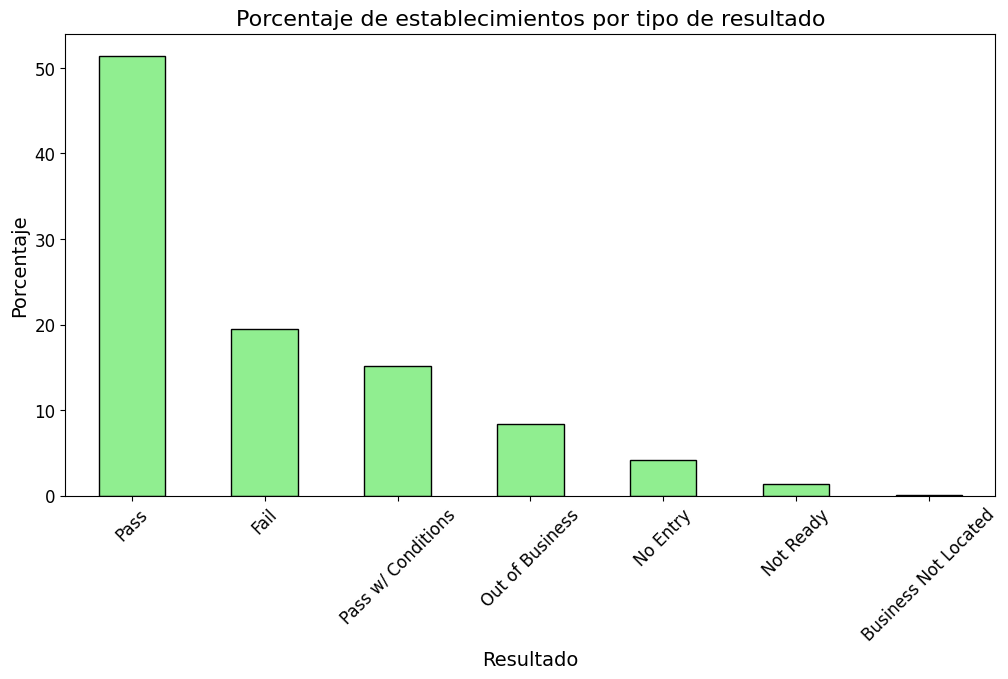

In [29]:
resultados_pct = (df['results'].value_counts() / len(df)) * 100
plt.figure(figsize=(12, 6))
ax = resultados_pct.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Porcentaje de establecimientos por tipo de resultado')
plt.ylabel('Porcentaje')
plt.xlabel('Resultado')
plt.xticks(rotation=45)
plt.show()


## 7. Mapa de inspecciones

In [31]:
def create_map(df):
    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    for idx, row in df.sample(n=1000).iterrows():
        color = 'green' if row['results'] == 'Pass' else 'red'
        folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        popup=f"Tipo: {row['facility_type']}<br>Resultado: {row['results']}",
        color=color,
        fill=True,
        fillColor=color
        ).add_to(m)
        return m
mapa = create_map(df)
mapa


## Generar reporte HTML

In [35]:
plt.rcParams['axes.unicode_minus'] = False

def fig_to_base64(fig):
    """Convierte una figura de Matplotlib en una cadena base64."""
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)  # Cerrar la figura después de guardarla
    return base64.b64encode(buf.getvalue()).decode("ascii")

# Regenerar las figuras y asegurarse de capturarlas correctamente
fig1 = plt.figure(figsize=(12, 6))
top_5_establecimientos.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 5 tipos de establecimientos')
fig1 = plt.gcf()

fig2 = plt.figure(figsize=(12, 6))
inspecciones_por_anio.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Inspecciones por año')
fig2 = plt.gcf()

fig3 = plt.figure(figsize=(12, 6))
top_5_inspecciones.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 5 tipos de inspecciones')
fig3 = plt.gcf()

fig4 = plt.figure(figsize=(12, 6))
top_5_inspecciones_pct.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Porcentaje de Top 5 tipos de inspecciones')
fig4 = plt.gcf()

fig5 = plt.figure(figsize=(12, 6))
resultados_pct.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Porcentaje de establecimientos por resultado')
fig5 = plt.gcf()

# Guardar el mapa de Folium
mapa.save('mapa_inspecciones.html')

# Leer el contenido del archivo HTML del mapa
with open('mapa_inspecciones.html', 'r', encoding='utf-8') as f:
    mapa_html = f.read()

# Generar el contenido del reporte HTML
html_content = f"""
<html>
<head>
    <title>Reporte de Análisis Exploratorio de Datos</title>
    <style>
        body {{ font-family: Arial, sans-serif; line-height: 1.6; color: #333; max-width: 800px; margin: 0 auto; padding: 20px; }}
        h1 {{ color: #2c3e50; border-bottom: 2px solid #2c3e50; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; }}
        img {{ max-width: 100%; height: auto; margin: 20px 0; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
        p {{ margin-bottom: 20px; }}
    </style>
</head>
<body>
    <h1>Reporte de Análisis Exploratorio de Datos</h1>
    
    <h2>1. Top 5 tipos de establecimientos</h2>
    <img src="data:image/png;base64,{fig_to_base64(fig1)}"/>
    <p>Observamos que los restaurantes son los más inspeccionados, seguidos de escuelas y tiendas de comestibles.</p>
    
    <h2>2. Inspecciones por año</h2>
    <img src="data:image/png;base64,{fig_to_base64(fig2)}"/>
    <p>El número de inspecciones ha variado significativamente por año.</p>
    
    <h2>3. Top 5 tipos de inspecciones</h2>
    <img src="data:image/png;base64,{fig_to_base64(fig3)}"/>
    <p>Las inspecciones canvass son las más comunes.</p>
    
    <h2>4. Porcentaje de los top 5 tipos de inspecciones</h2>
    <img src="data:image/png;base64,{fig_to_base64(fig4)}"/>
    <p>Estos tipos representan la mayoría de las inspecciones.</p>
    
    <h2>5. Porcentaje de establecimientos por resultado</h2>
    <img src="data:image/png;base64,{fig_to_base64(fig5)}"/>
    <p>La mayoría de los establecimientos pasan la inspección.</p>
    
    <h2>6. Mapa de inspecciones</h2>
    {mapa_html}
    <p>El mapa muestra la distribución de las inspecciones.</p>
</body>
</html>
"""

# Guardar el reporte HTML
with open('reporte_eda.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("Reporte HTML generado como 'reporte_eda.html'")



Reporte HTML generado como 'reporte_eda.html'
